In [46]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import torch
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import pyk4a
from pyk4a import Config, PyK4A

k4a = PyK4A(
    Config(
        color_resolution=pyk4a.ColorResolution.RES_720P,
        depth_mode=pyk4a.DepthMode.NFOV_UNBINNED,
        synchronized_images_only=True,
    )
)
k4a.start()

# getters and setters directly get and set on device
k4a.whitebalance = 4500
assert k4a.whitebalance == 4500
k4a.whitebalance = 4510
assert k4a.whitebalance == 4510

capture = k4a.get_capture()
color = capture.color
depth = capture.transformed_depth
k4a.stop()

In [112]:
# remove alpha channel
depth = torch.tensor(depth.astype(float), dtype=torch.double)
depth = depth[None, None, ...]

color = torch.tensor(color.astype(float), dtype=torch.double)
color = color[None, ..., :3].permute(0, 3, 1, 2)

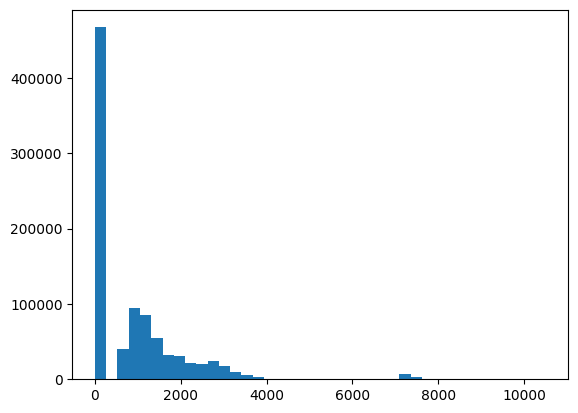

In [113]:
_ = plt.hist(depth.flatten(), bins=40)

In [114]:
mask = (depth > 10.0) * (depth < 5000.0)

In [15]:
from camera import Camera
from options import Options 
from dataset import CustomDataset

In [104]:
opt = Options()
defaults = opt.parser.parse_args([])
defaults.height = 720
defaults.width = 1280

cam = Camera(defaults)

In [16]:
dataset = CustomDataset(defaults)
dataLoader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

In [37]:
data = next(iter(dataLoader))

In [73]:
data[('color', 0)].shape

torch.Size([1, 3, 480, 640])

In [74]:
data[('depth', 0)].shape

torch.Size([1, 1, 480, 640])

In [35]:
optimizer = torch.optim.Adam(cam.parameters())
lossFunction = torch.nn.MSELoss()

In [115]:
print("Continue optimizing throughout trajectory")
for i in range(0, 50):
    optimizer.zero_grad()
    predColor = cam(depth, color)
    loss = lossFunction(predColor[mask], color[mask])
    loss.backward()
    optimizer.step()
    print("loss:", loss)

Continue optimizing throughout trajectory


RuntimeError: expected scalar type Double but found Float

In [44]:
img = predColor.detach().numpy()

In [50]:
img = img[0, :, :, :].transpose(1, 2, 0)

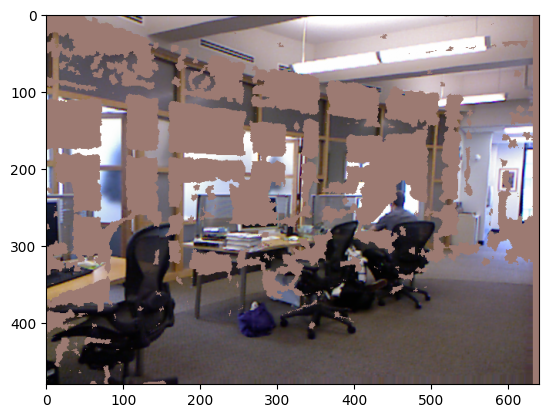

In [53]:
plt.imshow(img)